In [1]:
%matplotlib inline
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from torchdiffeq import odeint
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda:0


from the odeint docstring:
`odeint(func, y0, t, rtol=1e-7, atol=1e-9, method=None, options=None)`
Solves the initial value problem for a non-stiff system of first order ODEs:
        ```
        dy/dt = func(t, y), y(t[0]) = y0
        ```
where y is a Tensor of any shape.

Let's begin with the simplest differential equation: The harmonic oscillator.
  $$\ddot{y} = -y$$ 
Since the solver solves a first order ODE, we need two dimensions for f(t, y).
      $$\vec{y} = \begin{pmatrix}
                    y       \\
                    \dot{y} \\
                  \end{pmatrix} $$
We re-write:
$$
\frac{\mathrm{d}}{\mathrm{d}t}
\begin{pmatrix}
    y \\
    \dot{y} \\
\end{pmatrix}  = 
\begin{pmatrix}
    \dot{y} \\
    -y      \\
\end{pmatrix} 
$$

and find that we can express the second order DE as a matrix-vector multiplication:
$$  \frac{\mathrm{d}}{\mathrm{d}t}\vec{y} = 
\begin{pmatrix}
    0  & 1 \\
    -1 & 0 \\
\end{pmatrix}\vec{y}
$$



In [4]:
class Lambda(nn.Module):
    def __init__(self, A):
        super(Lambda, self).__init__()
        self.A = A
    def forward(self, t, y):
        return torch.mm(y, self.A) # matrix vector for each vector y in a batch

In [5]:
# If we begin with y = 0 and  dy/dt = 1, we should get a sine wave
data_size = 200
true_y0 = torch.tensor([[0., 1.]]) # a batch of size one
t = torch.linspace(0., 15., data_size)
# The matrix A from above has to be transposed.
# To compute A.y for each vector y we can then simply do y.A^T
true_A = torch.tensor(np.transpose([[0., 1], [-1., 0.]]), dtype=torch.float)

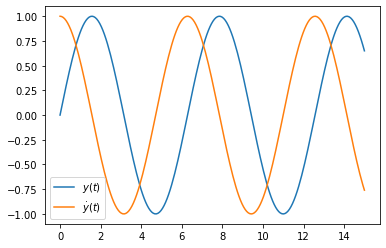

In [6]:
with torch.no_grad():
    true_y = odeint(Lambda(true_A), true_y0, t, method='dopri5')

# Let's see if that worked the way we wanted!
# here is only one batch, that is what the second index is for
plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], label=r'$y(t)$')
plt.plot(t.numpy(), true_y.numpy()[:, 0, 1], label=r'$\dot{y}(t)$')
plt.legend()

torch.Size([3, 2])


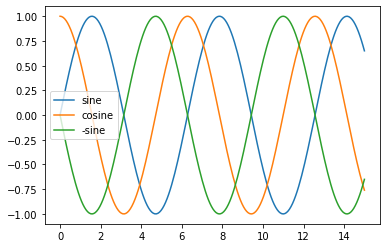

In [7]:
# make a batch of size three, with starting conditions for sine, cosine and -sine
data_size = 200
true_y0_batch = torch.tensor([[0., 1.], [1., 0.], [0., -1.]]) # a batch of size three
print(true_y0_batch.size())
with torch.no_grad():
    true_y_batch = odeint(Lambda(true_A), true_y0_batch, t, method='dopri5')

# You can see here that the second index is indeed the batch index
plt.plot(t.numpy(), true_y_batch.numpy()[:, 0, 0], label='sine')
plt.plot(t.numpy(), true_y_batch.numpy()[:, 1, 0], label='cosine')
plt.plot(t.numpy(), true_y_batch.numpy()[:, 2, 0], label='-sine')
plt.legend()

Let's assume that we don't know the true matrix $A$ in the differential equation and all we have to go on is some noisy datapoints along the curve. Can we recover $A$ through backpropagation through the ODE solver?

In [11]:
# first, we need a function to sample batches of points from the ground truth and add some noise
batch_size = 4 # how many time sequences are in each batch
batch_time = 40 # the length of each sequence
def get_batch(sigma=0.1):
    # sample <batch_size> starting times randomly from the vector of times in range
    s = torch.from_numpy(
        np.random.choice(
            np.arange(data_size - batch_time, dtype=np.int64),
            batch_size, replace=False
        )
    )
    batch_t0 = s # the starting time is only used for plotting, it is irrelevant for finding the ODE
    batch_y0 = true_y[s, 0]  # (M, D) for simplicity, we assume that we know the true starting position of each batch
    batch_t = t[:batch_time]  # (T)   batch times always begin at zero
    batch_y = torch.stack([true_y[s + i, 0] for i in range(batch_time)], dim=0)  # (T, M, D)
    if sigma > 0:
        batch_y += sigma*torch.randn(*batch_y.size())
    return batch_t0, batch_y0, batch_t, batch_y

In [12]:
batch_t0, batch_y0, batch_t, batch_y = get_batch()
print(batch_y0.size())
print(batch_t.size())
print(batch_y.size())

torch.Size([4, 2])
torch.Size([40])
torch.Size([40, 4, 2])


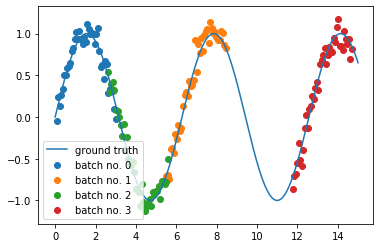

In [15]:
plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], label='ground truth')
for i in range(batch_size):
    this_sample_y = batch_y.numpy()[:, i, 0]
    plt.scatter(t.numpy()[batch_t0.numpy()[i]]+batch_t.numpy(), this_sample_y, label='batch no. {:d}'.format(i))
plt.legend()
plt.savefig('sampling_oscillator.png')

Now we initialize $A$ randomly and attempt to recover it with gradient descent

In [13]:
A_init = 0.1*torch.randn(2, 2)
print(A_init)

tensor([[-0.0106,  0.0149],
        [-0.0382, -0.0059]])


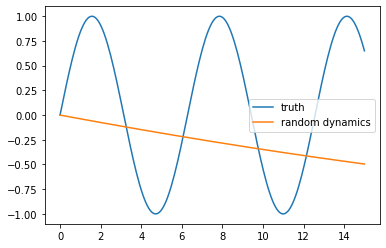

In [14]:
with torch.no_grad():
    reco_y = odeint(Lambda(A_init), true_y0, t, method='dopri5')

plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], label='truth')
plt.plot(t.numpy(), reco_y.numpy()[:, 0, 0], label='random dynamics')
plt.legend()

### Solving for the optimal matrix
The method below does not work with the adjoint method, because not every operation is a nn.Module.

In [15]:
from torchdiffeq import odeint

A_reco = A_init.clone().detach().requires_grad_(True)
print(A_reco)
print(true_A)
func = Lambda(A_reco)
optimizer = optim.SGD([A_reco], lr=1e-3)
criterion = nn.MSELoss(reduction='sum')
for i in range(100):
    optimizer.zero_grad()
    batch_t0, batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t, method='dopri5')
    # using chi-square errors (sum of squares)
    # only taking the first component (not fitting the velocity)    
    loss = criterion(pred_y[:, :, 0], batch_y[:, :, 0])
    loss.backward()
    optimizer.step()
    if i % 20 == 0:
        print(loss.item())
print(A_reco)

tensor([[-0.0106,  0.0149],
        [-0.0382, -0.0059]], requires_grad=True)
tensor([[ 0., -1.],
        [ 1.,  0.]])
386.4125671386719
15.370899200439453
5.500659942626953
4.591688632965088
3.7751598358154297
tensor([[-0.0064, -0.9920],
        [ 1.0050,  0.0029]], requires_grad=True)


### Solving using the Adjoint method
When the function is defined as below, using only nn.Module objects, the solution can be found using the adjoint method as well.

In [16]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.ll = nn.Linear(2, 2, bias=False)
        nn.init.normal_(self.ll.weight, mean=0, std=0.1)
    def forward(self, t, y):
        return self.ll(y)

In [ ]:
from torchdiffeq import odeint_adjoint as odeint

func = ODEFunc()
optimizer = optim.SGD(func.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='sum')
for i in range(100):
    optimizer.zero_grad()
    batch_t0, batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t, method='dopri5')
    loss = criterion(pred_y[:, :, 0], batch_y[:, :, 0])
    loss.backward()
    optimizer.step()
    if i % 20 == 0:
        print(loss.item())
print(list(func.parameters())[0])

In [17]:
from torchdiffeq import odeint_adjoint as odeint

A_reco = A_init.clone().detach().requires_grad_(True)
print(true_A)
func = ODEFunc()
optimizer = optim.SGD(func.parameters(), lr=1e-3)
print(list(func.parameters())[0])
criterion = nn.MSELoss(reduction='sum')
for i in range(100):
    optimizer.zero_grad()
    batch_t0, batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t, method='dopri5')
    # using chi-square errors (sum of squares)
    # only taking the first component (not fitting the velocity)    
    loss = criterion(pred_y[:, :, 0], batch_y[:, :, 0])
    loss.backward()
    optimizer.step()
    if i % 20 == 0:
        print(loss.item())
print(list(func.parameters())[0])

tensor([[ 0., -1.],
        [ 1.,  0.]])
Parameter containing:
tensor([[ 0.0019,  0.0165],
        [-0.0749, -0.0379]], requires_grad=True)
532.086669921875
17.25948143005371
6.63815975189209
4.198745250701904
4.033958435058594
Parameter containing:
tensor([[-0.0094,  0.9968],
        [-0.9952,  0.0074]], requires_grad=True)


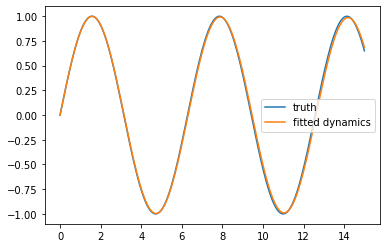

In [18]:
with torch.no_grad():
    true_y = odeint(Lambda(true_A), true_y0, t, method='dopri5')
    reco_y = odeint(func, true_y0, t, method='dopri5')
plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], label='truth')
plt.plot(t.numpy(), reco_y.numpy()[:, 0, 0], label='fitted dynamics')
plt.legend()

In [23]:
from torchdiffeq import odeint_adjoint as odeint

print(true_A)
func = ODEFunc().to(device)
optimizer = optim.SGD(func.parameters(), lr=1e-3)
print(list(func.parameters())[0])
criterion = nn.MSELoss(reduction='sum')
for i in range(100):
    optimizer.zero_grad()
    batch_t0, batch_y0, batch_t, batch_y = get_batch()
    batch_y0 = batch_y0.to(device)
    batch_t = batch_t.to(device)
    batch_y = batch_y.to(device)
    pred_y = odeint(func, batch_y0, batch_t, method='dopri5')
    # using chi-square errors (sum of squares)
    # only taking the first component (not fitting the velocity)    
    loss = criterion(pred_y[:, :, 0], batch_y[:, :, 0])
    loss.backward()
    optimizer.step()
    if i % 20 == 0:
        print(loss.item())
print(list(func.parameters())[0])

tensor([[ 0., -1.],
        [ 1.,  0.]])
Parameter containing:
tensor([[ 0.0993, -0.1398],
        [-0.0096, -0.0411]], device='cuda:0', requires_grad=True)
640.6974487304688
34.2828483581543
13.67900276184082
5.978187561035156
4.653087139129639
Parameter containing:
tensor([[-0.0260,  1.0031],
        [-0.9752,  0.0106]], device='cuda:0', requires_grad=True)
